<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 3
<br>
<b>Deadline:</b> May 20, 2020 (Wednesday) 23:00
</div>

# Exercise 10.1. Autoregressive generative models. PixelCNN

The goal of this exercise is to get familiar with autoregressive generative models using the PixelCNN model as an example.

The model is decribed in Section 3.5 of [this paper](https://arxiv.org/pdf/1601.06759.pdf).

**This exercise requires a significant amount of computing power, you need to use a GPU.**

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

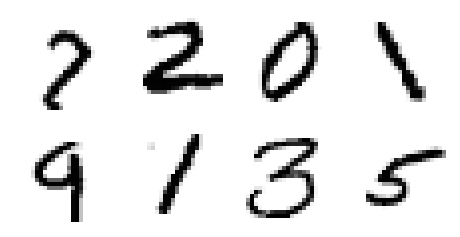

In [8]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])


# PixelCNN

<img src="pixelcnn_context.png" width=200 style="float: right; padding:20px;">

PixelCNN is an autoregressive model for the distribution of images.
The joint probability $p(x)$ of an $n \times n$ image $x$ is written as a product
of the conditional distributions over the pixels:
$$
  p(x) = \prod_{i=1}^{n^2} p(x_i|x_1,...,x_{i-1})
$$
The order of the pixels in the model is chosen arbitrarily. It is convenient to choose the first pixel $x_1$ to be in the top left corner and the last pixel $x_{n^2}$ in the bottom right corner (see the figure).

We model the conditional distribution $p(x_i|x_1,...,x_{i-1})$ using a deep convolutional neural network. This network is designed in the following way:
- The input and the output images have the same size.
- The value of pixel $i$ in the output image is only affected by pixels of the input image that precede $i$ (as shown on the figure). This can be achieved by a network which is a stack of masked convolutional layers.

# Masked convolutional layer

- A masked convolutional layer is a standard convolutional layer whose kernel has zero values below and to the right of the central location. The remaining values of the kernel are the parameters of the layer which are trained in a standard way.

- A simple way to implement the masked convolutional layer is to use a standard `nn.Conv2d` module and multiply its kernel by a binary mask in the `forward()` function.

- The layer can have two kinds of binary masks:
  1. with zero in the center (`blind_center=True`):
<img src="masked_conv.png" width=150>
  2. with one in the center (`blind_center=False`):
<img src="masked_conv_2.png" width=150>

  We will use the first type of mask in the first layer of our PixelCNN model and the second type of mask in the remaining layers. This kind of masking ensures that the output pixels are not affected by subsequent pixels of the input image.

- You can create the binary mask using function [`register_buffer`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.register_buffer). This way the mask will be automatically transferred to the given device when calling `model.to(device)`.

- The convolutional layer should **not** have a bias term because the biases are not affected by the mask.

You need to implement the masked convolutional layer in the cell below.

In [9]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        """
        Args:
          in_channels (int): Number of input channels.
          out_channels (int): Number of output channels.
          kernel_size (int): Kernel size similar to nn.Conv2d layer.
          blind_center (bool): If True, the kernel has zero in the center.
        """
        # YOUR CODE HERE
        super(MaskedConv2d, self).__init__()
        mask = np.zeros([out_channels, in_channels, kernel_size, kernel_size], dtype=np.float32)
        h, w = kernel_size // 2, kernel_size // 2
        if(blind_center == True):
            mask[:, :, :h,:] = 1
            mask[:, :,h, :w ] = 1
        else:
            mask[:, :, :h,:] = 1
            mask[:, :,h, :w + 1] = 1
            
        mask = torch.from_numpy(mask).float()
        self.register_buffer('mask', mask)
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,  bias = False, padding = padding)
#         raise NotImplementedError()

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, in_channels, height, width): Input images.
        
        Returns:
          y of shape (batch_size, out_channels, height, width): Output images.
        """
        # YOUR CODE HERE
        self.conv.weight.data *= self.mask
        x = self.conv(x)
        return x

In [10]:
def test_MaskedConv2d_shapes():
    layer = MaskedConv2d(in_channels=1, out_channels=2, kernel_size=5, blind_center=False)
    x = torch.ones(1, 1, 28, 28)
    y = layer(x)
    assert y.shape == torch.Size([1, 2, 28, 28]), f"Bad y.shape: {y.shape}"

test_MaskedConv2d_shapes()

In [11]:
tests.test_MaskedConv2d(MaskedConv2d)

y:
 tensor([[-0.0800, -0.1600, -0.2400, -0.2400, -0.2400, -0.2400, -0.2400, -0.2400],
        [-0.3200, -0.4800, -0.6400, -0.6400, -0.6400, -0.6400, -0.5600, -0.4800],
        [-0.5600, -0.8000, -1.0400, -1.0400, -1.0400, -1.0400, -0.8800, -0.7200],
        [-0.5600, -0.8000, -1.0400, -1.0400, -1.0400, -1.0400, -0.8800, -0.7200],
        [-0.4000, -0.4800, -0.5600, -0.5600, -0.5600, -0.5600, -0.4000, -0.2400],
        [ 0.0800,  0.1600,  0.2400,  0.2400,  0.2400,  0.2400,  0.2400,  0.2400],
        [ 0.5600,  0.8000,  1.0400,  1.0400,  1.0400,  1.0400,  0.8800,  0.7200],
        [ 0.5600,  0.8000,  1.0400,  1.0400,  1.0400,  1.0400,  0.8800,  0.7200]],
       grad_fn=<SelectBackward>)
expected:
 tensor([[-0.0800, -0.1600, -0.2400, -0.2400, -0.2400, -0.2400, -0.2400, -0.2400],
        [-0.3200, -0.4800, -0.6400, -0.6400, -0.6400, -0.6400, -0.5600, -0.4800],
        [-0.5600, -0.8000, -1.0400, -1.0400, -1.0400, -1.0400, -0.8800, -0.7200],
        [-0.5600, -0.8000, -1.0400, -1.0400, -1.0

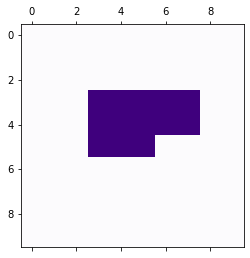

In [12]:
# Inspect the receptive field of one neuron in the masked convolutional layer
layer = MaskedConv2d(in_channels=1, out_channels=2, kernel_size=5, blind_center=False)

# Receptive field for output pixel at location (5, 5), input-output images of size (10x10)
i, j = 5, 5
rfield = tests.get_binary_receptive_field(layer, image_size=(10, 10), i=i, j=j)
plt.matshow(rfield, cmap=plt.cm.Purples, clim=[0, 1])

### Visualize receptive field of many layers stacked on top of each other

Let us stack a few `MaskedConv2d` layers on top of each other and visualize the receptive field for one of the output pixels.

In [13]:
# Stack multiple layers
net = nn.Sequential(
    MaskedConv2d(in_channels=1, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=False),
    nn.Conv2d(2, 256, 1)
)

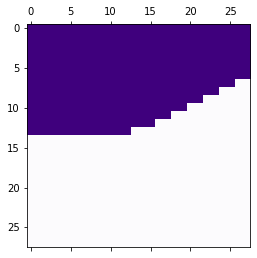

In [14]:
# Visualize receptive field
rfield = tests.get_binary_receptive_field(net, image_size=(28, 28), i=13, j=13)
plt.matshow(rfield, cmap=plt.cm.Purples, clim=[0, 1])

If your implementation of the masked convolutional layer is correct, you should see the blind spot problem: Some of the preceding pixels do not affect the value of the pixel at (13, 13). We will not try to address the blind-spot problem in this notebook.

# PixelCNN model

Next you need to implement the PixelCNN model which is simply a stack of `MaskedConv2d` layers.

The recommended architecture is:
* Masked convolutional layer with 1 input channel, `n_channels` output channels, given `kernel_size`, `blind_center=True`
* 2d batch normalization followed by ReLU nonlinearity
* 7 blocks with:
    * Masked convolutional layer with `n_channels` input channels, `n_channels` output channels, given `kernel_size`, `blind_center=False`
    * 2d batch normalization followed by ReLU nonlinearity
* $1 \times 1$ convolution with `n_channels` input channels and 256 output channels.
* **Do not use the softmax nonlinearity in the forward function. Our tests assume that the loss function is [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) with the log-softmax implemented there.**

Hints:
* We do not test the architecture of the PixelCNN model.
* **We recommend you to check receptive fields of different outputs in your PixelCNN model to make sure that the outputs are not affected by subsequent pixels (pixels below and to the right).**

### About using 2d batch normalization in the model

Using the batch normalization significantly improves the convergence of the training procedure. However, when the network is in the `train()` mode (that means that the batch norm uses statistics computed from the mini-batch), the batch norm breaks the required causality structure of the PixelCNN model. Since all the locations contribute to the batch statistics, the subsequent pixels affect the values of the previous pixels. Even though, the batch normalization represents the whole batch using only two statistics, the network seems to learn to make use of the information in the subsequent pixels. This is a possible explanation of the following observation: the loss computed in the `eval()` mode can be substantially larger compared to the loss computed in the `train()` mode.

When the network is used in the `eval()` model, the required causality structure is preserved. Even though using running statistics may result in larger loss values, it does not seem to affect significantly the quality of the generated images.

In [15]:
class PixelCNN(nn.Module):
    def __init__(self, n_channels=64, kernel_size=7):
        """PixelCNN model."""
        super(PixelCNN, self).__init__()
        # YOUR CODE HERE
        self.maskedcnn = MaskedConv2d(1, n_channels, kernel_size, blind_center=True)
        self.b_norm = nn.BatchNorm2d(n_channels)
        self.block1 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block2 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block3 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block4 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block5 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block6 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        self.block7 = nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center = False),
                                  nn.BatchNorm2d(n_channels),
                                  nn.ReLU(True))
        
        self.conv_1x1 = nn.Conv2d(n_channels, 256, kernel_size = 1)
#         raise NotImplementedError()

    def forward(self, x):
        """Compute logits of the conditional probabilities p(x_i|x_1, ..., x_{i-1}) of the PixelCNN model.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Tensor of input images.
        
        Returns:
          logits of shape (batch_size, 256, 28, 28): Tensor of logits of the conditional probabilities
                                                      for each pixel.
        
        NB: Do not use softmax nonlinearity after the last layer.
        """
        # YOUR CODE HERE
        x = F.relu(self.b_norm(self.maskedcnn(x)))
        # for _ in range(7):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.conv_1x1(x)
        return x
#         raise NotImplementedError()

In [16]:
def test_PixelCNN_shapes():
    net = PixelCNN(n_channels=64, kernel_size=7)

    batch_size = 32
    x = torch.randn(batch_size, 1, 28, 28)
    y = net(x)
    assert y.shape == torch.Size([batch_size, 256, 28, 28]), f"Bad y.shape: {y.shape}"
    print('Success')

test_PixelCNN_shapes()

Success


In [17]:
# This cell tests that the outputs are not affected by subsequent pixels (pixels below and to the right).

### Loss function for training PixelCNN

Next we implement the loss function used to train the PixelCNN model. Note that in PixelCNN, the conditional distributions $p(x_i|x_1,...,x_{i-1})$ of pixel intensities $x_i$ are multinomial distributions over 256 possible values. Thus, the loss function is the mean of the cross-entropy classification losses with 256 classes computed for each pixel $x_i$.

In [18]:
def loss_fn(logits, x):
    """Compute PixelCNN loss. The PixelCNN model uses conditional distributions $p(x_i|x_1,...,x_{i-1})$
    for pixel intensities x_i which are multinomial distributions over 256 possible values. Thus the loss
    function is the cross-entropy classification loss with 256 intensity values computed for each pixel x_i.

    NB: Our tests assume the cross-entropy loss function which has log_softmax implemented inside,
    such as `nn.CrossEntropyLoss`.

    Args:
      logits of shape (batch_size, 256, 28, 28): Logits of the conditional probabilities
                  p(x_i | x_1,...,x_{i-1}) of the 256 intensities of pixel x_i computed using all
                  previous pixel value x_1,...,x_{i-1}.
      x of shape (batch_size, 1, 28, 28): Images used to produce `generated_x`. The values of pixel
                  intensities in x are between 0 and 1.

    Returns:
      loss: Scalar tensor which contains the value of the loss.
    """
    # YOUR CODE HERE
    criterion = nn.CrossEntropyLoss()
    batch_size = x.shape[0]
    logits = logits.view(batch_size, 256, -1)
    x = x.view(batch_size, -1)
    x = x * 255
    loss = criterion(logits, x.type(torch.LongTensor))
    return loss
#     raise NotImplementedError()

In [19]:
# Test of PixelCNN loss
def test_loss_fn():
    net = PixelCNN(n_channels=1, kernel_size=5)

    generated_x = torch.ones(1, 256, 28, 28)
    x = .5 * torch.ones(1, 1, 28, 28)
    loss = loss_fn(generated_x, x)
    expected = torch.tensor(5.5452)
    
    print('loss:', loss)
    print('expected:', expected)
    assert torch.allclose(loss, expected), "loss does not match expected value."
    print('Success')

test_loss_fn()

loss: tensor(5.5452)
expected: tensor(5.5452)
Success


### Generation procedure

Next we implement the procedure that generates samples using a PixelCNN model. The generation proceeds as follows:
* Initialize `samples` tensor as images with all zeros.
* Apply the PixelCNN model to `samples` tensor. The output will contain logits (probabilities before softmax) over 256 pixel intensity values for pixels in all locations. However, on the first iteration we are only interested in the pixel intensities at the first location (0,0) because we need to compute
$$p(x_1)$$.
* Use computed probabilities to sample a pixel intensity value for the pixel at location (0, 0). Write the sampled value to location (0, 0) of the `samples` tensor.
* Apply the model to the `samples` tensor. Now the sampled value of $x_1$ is used by the model to generate the probabilities of pixel intensities for the pixel at location (0, 1), thus we computed
$$p(x_2\mid x_1).$$

* We sample a pixel intensity value for the second pixel and write it to the corresponding location of `samples` tensor.
* We continue until we change all the values of the `samples` tensor.

Hints:
* **Do not forget to set the model into the evaluation mode by `net.eval()`.**
* Remember that the pixels of the generated images should have values between 0 and 1!

In [20]:
def generate(net, n_samples, image_size=(28, 28), device='cpu'):
    """Generate samples using a trained PixelCNN model.

    Args:
      net:        PixelCNN model.
      n_samples:  Number of samples to generate.
      image_size: Tuple of image size (height, width).
      device:     Device to use.
    
    Returns:
      samples of shape (n_samples, 1, height, width): Generated samples.
    """
    # YOUR CODE HERE
    sample = torch.Tensor(n_samples, 1, image_size[0], image_size[1]).to(device)
    sample.fill_(0)

    # for k in range(n_samples):
    for i in range(image_size[0]):
        for j in range(image_size[0]):
            net.eval()
            out = net(sample)
            probs = F.softmax(out[:,:,i,j], dim = 1).data
            # print(torch.multinomial(probs, 1).float())
            sample[:,:,i,j] = torch.multinomial(probs, 1) / 255.0

    return sample
#     raise NotImplementedError()

In [21]:
# Test of generation
def test_generate():
    net = PixelCNN(n_channels=1, kernel_size=5)
    
    # monkey-patching net.forward
    def my_forward(x):
        logits = torch.zeros(1, 256, 28, 28)
        ix = min((x[0, :, :, :]*255 + 1).long().max(), 255)
        logits[0, ix] = 100
        return logits
        
    net.forward = my_forward
    
    samples = generate(net, n_samples=1, image_size=(28, 28), device='cpu')
    expected = torch.arange(1, 29) / 255.
    print('samples[0, 0, 0]:\n', samples[0, 0, 0])
    print('expected:\n', expected)
    assert torch.allclose(samples[0, 0, 0], expected), "samples does not match expected value."
    print('Success')

test_generate()

samples[0, 0, 0]:
 tensor([0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314, 0.0353,
        0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667, 0.0706,
        0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020, 0.1059,
        0.1098])
expected:
 tensor([0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314, 0.0353,
        0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667, 0.0706,
        0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020, 0.1059,
        0.1098])
Success


# Train PixelCNN model

In [22]:
# Create a model
net = PixelCNN(n_channels=64, kernel_size=7)
net.to(device)

PixelCNN(
  (maskedcnn): MaskedConv2d(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  )
  (b_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Sequential(
    (0): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3): Sequential(
    (0): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): R

In [23]:
# Plot generated samples for an untrained model
# Note: generation on CPU may take a significant amount of time
if not skip_training:
    net.to(device)
    samples = generate(net, n_samples=120, device=device)
    tools.plot_generated_samples(samples, ncol=10)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 11. If you train for more epochs, the cost function may decrease further but the quality of the generated samples may degrade because of overfitting.

Hints:
- The loss at convergence can reach 0.63.
- Please use this code to plot 120 generated samples after each epoch. This will allow you to track the training progress.
```
with torch.no_grad():
    samples = generate(net, n_samples=120, device=device)
    tools.plot_generated_samples(samples)
```
- The generated images may not be of great quality but you should definitely generate digit-like images.
- **Do not forget to set the model into the training mode by `net.train()` before training.**
- The generated samples are expected to look similar to this:
<img src="pixelcnn_generated_samples.png" width=500>

In [24]:
import time
if not skip_training:
    # YOUR CODE HERE
    time_start = time.time()
    epochs = 11
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    for i in range(epochs):
        net.train()
        step = 0
        loss_= 0
        for images, labels in trainloader:
            images = images.to(device)
            
            optimizer.zero_grad()
            
            output = net(images)
            
            loss = loss_fn(output, images)
            
            loss.backward()
            optimizer.step()

            step += 1

            if(step%100 == 0):
                print('Epoch:'+str(i)+'\t'+ str(step) +'\t Iterations Complete \t'+'loss: ', loss.item())
        print('Epoch: '+str(i)+' Over!')
        with torch.no_grad():
          samples = generate(net, n_samples=120, device=device)
          tools.plot_generated_samples(samples)
    print('Training Finished! Time Taken: ', time.time()-time_start)
#     raise NotImplementedError()

In [25]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(net, '10_pixelcnn.pth')
else:
    net = PixelCNN(n_channels=64, kernel_size=7)
    tools.load_model(net, '10_pixelcnn.pth', device)

Model loaded from 10_pixelcnn.pth.


### Generate samples

In [26]:
if not skip_training:
    with torch.no_grad():
        samples = generate(net, n_samples=120, device=device)
        tools.plot_generated_samples(samples)

In [ ]:
# This cell tests the training loss of the trained PixelCNN model

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train PixelCNN, an autoregressive generative model of images.